In [43]:
# Imports
import yfinance as yf
from talib import abstract
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Download historical market data
ticker = "SPY"
stock = yf.Ticker(ticker)

# get historical market data
hist = stock.history(period="3y")

In [45]:
# # Download historical data as dataframe
spy_data = yf.download('SPY', start='2020-01-01', end='2023-06-30')

[*********************100%***********************]  1 of 1 completed


In [46]:
spy_data.to_csv('./Resources/SPY_3ydata.csv')

In [47]:
spy_3y_df = pd.read_csv(
    Path('./Resources/SPY_3ydata.csv'),
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

#Review the data frame

display(spy_3y_df.head())
display(spy_3y_df.tail())
display(spy_3y_df.info())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,307.375671,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,305.048126,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,306.211914,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,305.350922,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,306.978271,68296000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-23,432.929993,435.059998,432.470001,433.209991,433.209991,92074500
2023-06-26,432.619995,434.609985,431.190002,431.440002,431.440002,72823600
2023-06-27,432.350006,436.809998,431.880005,436.170013,436.170013,72813700
2023-06-28,435.049988,437.440002,434.410004,436.390015,436.390015,75636000
2023-06-29,435.959991,438.279999,435.540009,438.109985,438.109985,67882300


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 879 entries, 2020-01-02 to 2023-06-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       879 non-null    float64
 1   High       879 non-null    float64
 2   Low        879 non-null    float64
 3   Close      879 non-null    float64
 4   Adj Close  879 non-null    float64
 5   Volume     879 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 48.1 KB


None

## Establish a baseline with the source data

In [48]:
#take the Close data
spy_signals = spy_3y_df.loc[:, ['Close']]

display(spy_signals.head())
display(spy_signals.tail())
display(spy_signals.info())

,Close
Date,
2020-01-02,324.869995
2020-01-03,322.410004
2020-01-06,323.640015
2020-01-07,322.730011
2020-01-08,324.450012


,Close
Date,
2023-06-23,433.209991
2023-06-26,431.440002
2023-06-27,436.170013
2023-06-28,436.390015
2023-06-29,438.109985


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 879 entries, 2020-01-02 to 2023-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   879 non-null    float64
dtypes: float64(1)
memory usage: 13.7 KB


None

In [49]:
# Calculate the actual returns

spy_signals['Actual Returns'] = spy_signals['Close'].pct_change()

#Drop the NaN values

spy_signals = spy_signals.dropna()

#review the dataframe
display(spy_signals.head())
display(spy_signals.tail())
display(spy_signals.info())

,Close,Actual Returns
Date,,
2020-01-03,322.410004,-0.007572
2020-01-06,323.640015,0.003815
2020-01-07,322.730011,-0.002812
2020-01-08,324.450012,0.005330
2020-01-09,326.649994,0.006781


,Close,Actual Returns
Date,,
2023-06-23,433.209991,-0.007560
2023-06-26,431.440002,-0.004086
2023-06-27,436.170013,0.010963
2023-06-28,436.390015,0.000504
2023-06-29,438.109985,0.003941


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 878 entries, 2020-01-03 to 2023-06-29
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           878 non-null    float64
 1   Actual Returns  878 non-null    float64
dtypes: float64(2)
memory usage: 20.6 KB


None

In [50]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
spy_signals['SMA_Short'] = spy_signals['Close'].rolling(window=short_window).mean()
spy_signals['SMA_Long'] = spy_signals['Close'].rolling(window=long_window).mean()

# Drop NaN again from the new columns - Short and Long SMA

spy_signals = spy_signals.dropna()

# Review the DataFrame
display(spy_signals.head())
display(spy_signals.tail())
display(spy_signals.info())

,Close,Actual Returns,SMA_Short,SMA_Long
Date,,,,
2020-05-27,303.529999,0.014879,298.232498,295.964602
2020-05-28,302.970001,-0.001845,300.254997,295.770202
2020-05-29,304.320007,0.004456,302.474998,295.577002
2020-06-01,305.549988,0.004042,304.092499,295.405201
2020-06-02,308.079987,0.008280,305.229996,295.241501


,Close,Actual Returns,SMA_Short,SMA_Long
Date,,,,
2023-06-23,433.209991,-0.007560,435.459999,410.842800
2023-06-26,431.440002,-0.004086,434.025002,411.092400
2023-06-27,436.170013,0.010963,434.332504,411.346100
2023-06-28,436.390015,0.000504,434.302505,411.542201
2023-06-29,438.109985,0.003941,435.527504,411.799800


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 779 entries, 2020-05-27 to 2023-06-29
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           779 non-null    float64
 1   Actual Returns  779 non-null    float64
 2   SMA_Short       779 non-null    float64
 3   SMA_Long        779 non-null    float64
dtypes: float64(4)
memory usage: 30.4 KB


None

In [51]:
# Initialize the new Signal column
spy_signals['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long term
spy_signals.loc[(spy_signals['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short term
spy_signals.loc[(spy_signals['Actual Returns'] < 0), 'Signal'] = -1


# Review the DataFrame
display(spy_signals.head())
display(spy_signals.tail())
display(spy_signals.info())

,Close,Actual Returns,SMA_Short,SMA_Long,Signal
Date,,,,,
2020-05-27,303.529999,0.014879,298.232498,295.964602,1.0
2020-05-28,302.970001,-0.001845,300.254997,295.770202,-1.0
2020-05-29,304.320007,0.004456,302.474998,295.577002,1.0
2020-06-01,305.549988,0.004042,304.092499,295.405201,1.0
2020-06-02,308.079987,0.008280,305.229996,295.241501,1.0


,Close,Actual Returns,SMA_Short,SMA_Long,Signal
Date,,,,,
2023-06-23,433.209991,-0.007560,435.459999,410.842800,-1.0
2023-06-26,431.440002,-0.004086,434.025002,411.092400,-1.0
2023-06-27,436.170013,0.010963,434.332504,411.346100,1.0
2023-06-28,436.390015,0.000504,434.302505,411.542201,1.0
2023-06-29,438.109985,0.003941,435.527504,411.799800,1.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 779 entries, 2020-05-27 to 2023-06-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           779 non-null    float64
 1   Actual Returns  779 non-null    float64
 2   SMA_Short       779 non-null    float64
 3   SMA_Long        779 non-null    float64
 4   Signal          779 non-null    float64
dtypes: float64(5)
memory usage: 36.5 KB


None

In [52]:
#Verify data in 'Signal' column is balanced
spy_signals['Signal'].value_counts()

 1.0    415
-1.0    364
Name: Signal, dtype: int64

In [53]:
## Calculate Strategy returns based on the Signal
spy_signals['Strategy Returns'] = spy_signals['Actual Returns'] * spy_signals['Signal'].shift()

#drop the NaNs

spy_signals = spy_signals.dropna()

#review the df

display(spy_signals.head())
display(spy_signals.tail())
display(spy_signals.info())

,Close,Actual Returns,SMA_Short,SMA_Long,Signal,Strategy Returns
Date,,,,,,
2020-05-28,302.970001,-0.001845,300.254997,295.770202,-1.0,-0.001845
2020-05-29,304.320007,0.004456,302.474998,295.577002,1.0,-0.004456
2020-06-01,305.549988,0.004042,304.092499,295.405201,1.0,0.004042
2020-06-02,308.079987,0.008280,305.229996,295.241501,1.0,0.008280
2020-06-03,312.179993,0.013308,307.532494,295.096801,1.0,0.013308


,Close,Actual Returns,SMA_Short,SMA_Long,Signal,Strategy Returns
Date,,,,,,
2023-06-23,433.209991,-0.007560,435.459999,410.842800,-1.0,-0.007560
2023-06-26,431.440002,-0.004086,434.025002,411.092400,-1.0,0.004086
2023-06-27,436.170013,0.010963,434.332504,411.346100,1.0,-0.010963
2023-06-28,436.390015,0.000504,434.302505,411.542201,1.0,0.000504
2023-06-29,438.109985,0.003941,435.527504,411.799800,1.0,0.003941


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 778 entries, 2020-05-28 to 2023-06-29
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Close             778 non-null    float64
 1   Actual Returns    778 non-null    float64
 2   SMA_Short         778 non-null    float64
 3   SMA_Long          778 non-null    float64
 4   Signal            778 non-null    float64
 5   Strategy Returns  778 non-null    float64
dtypes: float64(6)
memory usage: 42.5 KB


None

<Axes: xlabel='Date', ylabel='Strategy Returns'>

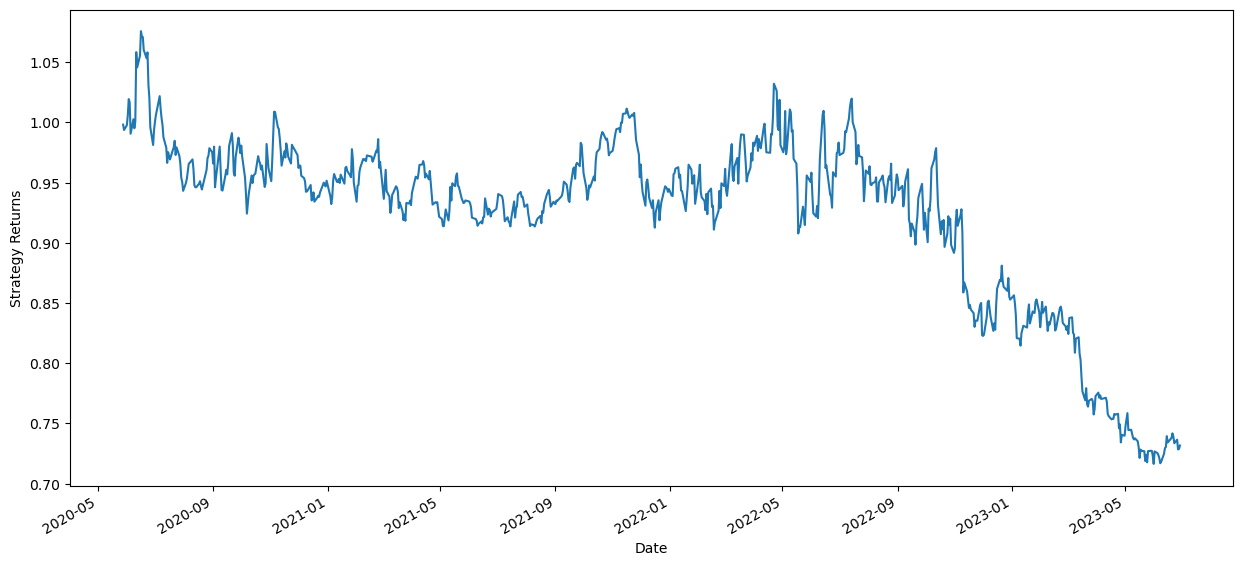

In [54]:
# PLot the data frame
(1+spy_signals['Strategy Returns']).cumprod().plot(figsize=(15,7), ylabel = 'Strategy Returns')

#### Training the Model

In [55]:
# Define the data for 'X'
X = spy_signals[['SMA_Short','SMA_Long']].shift().dropna()

# Inspect the dataframe

display(X.head())
display(X.tail())
display(X.info())

,SMA_Short,SMA_Long
Date,,
2020-05-29,300.254997,295.770202
2020-06-01,302.474998,295.577002
2020-06-02,304.092499,295.405201
2020-06-03,305.229996,295.241501
2020-06-04,307.532494,295.096801


,SMA_Short,SMA_Long
Date,,
2023-06-23,437.022499,410.516600
2023-06-26,435.459999,410.842800
2023-06-27,434.025002,411.092400
2023-06-28,434.332504,411.346100
2023-06-29,434.302505,411.542201


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 777 entries, 2020-05-29 to 2023-06-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMA_Short  777 non-null    float64
 1   SMA_Long   777 non-null    float64
dtypes: float64(2)
memory usage: 18.2 KB


None

In [56]:
# Define data for y

y = spy_signals[['Signal']]

#inspect the data frame

# display(y.head())
# display(y.tail())
display(y.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 778 entries, 2020-05-28 to 2023-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Signal  778 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB


None

In [57]:
y.value_counts()

Signal
 1.0      414
-1.0      364
dtype: int64

In [58]:
#Prepare Training data by defining Training Begining and Ending periods

#Function to calculate number of trading days in the data set

import pandas_market_calendars as mcal

def calculate_trading_days(start_date, end_date):
    # Create a calendar object for the NYSE
    nyse = mcal.get_calendar('NYSE')

    # Get the schedule of trading days between the start and end dates
    schedule = nyse.schedule(start_date=start_date, end_date=end_date)

    # Calculate the number of trading days
    num_trading_days = len(schedule.index)

    return num_trading_days

In [59]:
# Use function to calculate number of Trading Days in the data set

start_date = X.index.min()
end_date = X.index.max()

num_trading_days = calculate_trading_days(start_date, end_date)
print("Number of trading days:", num_trading_days)

Number of trading days: 777


In [60]:
# Calculate number of days in Training set For a 70/30 split

#Define split
train_split = 0.7

#calculate training data size
train_size = int(num_trading_days*train_split)
display(train_size)

543

In [61]:
# Define function to add Trading days to a given date:

def add_trading_days(start_date, num_days):
    nyse = mcal.get_calendar('NYSE')
    count = 0
    target_date = None

    while count < num_days:
        start_date += pd.DateOffset(days=1)
        if nyse.valid_days(start_date, start_date).size:
            count += 1

    target_date = start_date
    return target_date

In [62]:
# Calculate Training End date by adding the number of Trading days in the Train  
# split approach (70/30) to the Training start date

start_date = X.index.min() #pd.to_datetime('2020-05-29')
num_days = train_size
target_date = add_trading_days(start_date, num_days)
print("Target Date:", target_date)

Target Date: 2022-07-26 00:00:00


In [63]:
# Validate that the training end date matches the desired training set size
start_date = X.index.min()
end_date = target_date

num_trading_days = calculate_trading_days(start_date, end_date)
print("Number of trading days:", num_trading_days)

Number of trading days: 544


In [64]:
train_start = X.index.min()
train_end = target_date

print('The training START date is:', train_start)
print('The training END date is:', train_end)
print('The number of trading days in the training dataset is:',train_size,', which is close/matches the required training data size of:',num_trading_days)

The training START date is: 2020-05-29 00:00:00
The training END date is: 2022-07-26 00:00:00
The number of trading days in the training dataset is: 543 , which is close/matches the required training data size of: 544


In [65]:
# Define the training data in for the training start/end dates
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]

#review the training data set

display(X_train.head())
display(X_train.tail())
display(X_train.info())

,SMA_Short,SMA_Long
Date,,
2020-05-29,300.254997,295.770202
2020-06-01,302.474998,295.577002
2020-06-02,304.092499,295.405201
2020-06-03,305.229996,295.241501
2020-06-04,307.532494,295.096801


,SMA_Short,SMA_Long
Date,,
2022-07-20,384.315002,413.846001
2022-07-21,388.529999,413.510701
2022-07-22,391.945000,413.121101
2022-07-25,395.229996,412.705701
2022-07-26,396.055000,412.361601


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2020-05-29 to 2022-07-26
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMA_Short  544 non-null    float64
 1   SMA_Long   544 non-null    float64
dtypes: float64(2)
memory usage: 12.8 KB


None

In [66]:
# Generate the X_test and y_test DataFrames

#Determine Testing Date START and Testing END

test_start = train_end + DateOffset(days=1)
test_end = X.index.max()

#number od trading days in the testing data set
start_date = test_start
end_date = test_end

num_trading_days_test = calculate_trading_days(start_date, end_date)

print('The testing START date is:', test_start)
print('The testing END date is:', test_end)
print('The number of trading days in the testing dataset is:',num_trading_days_test)

The testing START date is: 2022-07-27 00:00:00
The testing END date is: 2023-06-29 00:00:00
The number of trading days in the testing dataset is: 233


In [67]:
X_test = X.loc[test_start:test_end]
y_test = y.loc[test_start:test_end]

#review the Testing data set

display(X_test.head())
display(X_test.tail())
display(X_test.info())

,SMA_Short,SMA_Long
Date,,
2022-07-27,395.085007,411.891601
2022-07-28,395.647507,411.544901
2022-07-29,398.392509,411.283901
2022-08-01,402.497505,411.209501
2022-08-02,407.467499,411.154701


,SMA_Short,SMA_Long
Date,,
2023-06-23,437.022499,410.516600
2023-06-26,435.459999,410.842800
2023-06-27,434.025002,411.092400
2023-06-28,434.332504,411.346100
2023-06-29,434.302505,411.542201


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233 entries, 2022-07-27 to 2023-06-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMA_Short  233 non-null    float64
 1   SMA_Long   233 non-null    float64
dtypes: float64(2)
memory usage: 5.5 KB


None

In [68]:
display (y.shape)

(778, 1)

In [69]:
display(y_train.shape)

(544, 1)

In [70]:
y_train['Signal'].value_counts()

 1.0    300
-1.0    244
Name: Signal, dtype: int64

In [71]:
display (y_test.shape)

(233, 1)

In [72]:
y_test['Signal'].value_counts()

-1.0    119
 1.0    114
Name: Signal, dtype: int64

## Evaluate the Model

In [73]:
#Scale the data
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [74]:
# Import the AdaBoostClassifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
abc_model = AdaBoostClassifier()

In [75]:
# Fit the model using the training data
abc_model.fit(X_train_scaled, y_train)

AdaBoostClassifier()

In [78]:
# Use the testing dataset to generate the predictions for the new model
abc_train_pred = abc_model.predict(X_train_scaled)

# Review the model's predicted values
abc_train_pred[:20]

array([ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1., -1.,  1.])

In [79]:
abc_train_pred.shape

(544,)

In [80]:
# Use a classification report to evaluate the model using the predictions and testing data
abc_train_report70 = classification_report(y_train, abc_train_pred)

# Print the classification report
print(abc_train_report70)

              precision    recall  f1-score   support

        -1.0       0.74      0.44      0.55       244
         1.0       0.66      0.87      0.75       300

    accuracy                           0.68       544
   macro avg       0.70      0.66      0.65       544
weighted avg       0.69      0.68      0.66       544



In [81]:
# Use the trained model to predict trading signals using the test data
abc_test_pred = abc_model.predict(X_test_scaled)

In [82]:
# Generate the classification report for the test run
abc_test_report30 = classification_report(y_test, abc_test_pred)

#Review the report
print(abc_test_report30)

              precision    recall  f1-score   support

        -1.0       0.50      0.12      0.19       119
         1.0       0.49      0.88      0.63       114

    accuracy                           0.49       233
   macro avg       0.49      0.50      0.41       233
weighted avg       0.49      0.49      0.40       233



In [83]:
# Specify the file path and name
file_path = './Results/abc_test30_report.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write the report to the file
    file.write(abc_test_report30)

# Confirmation message
print(f"Report saved to {file_path}")

Report saved to ./Results/abc_test30_report.txt


In [84]:
# Create a new empty predictions DataFrame to compare the prediction results

# Create a predictions DataFrame
abc_predictions_df = pd.DataFrame(index=X_test.index)

# Add the model predictions to the DataFrame
abc_predictions_df['AbC Predicted Signals'] = abc_test_pred

# Add the actual returns to the DataFrame
abc_predictions_df ['Actual Returns'] = spy_signals['Actual Returns']


#Add the Logistic Regression Strategy Predicted Returns to the Data Frame 
abc_predictions_df['AbC Returns'] = spy_signals['Actual Returns'] * abc_predictions_df['AbC Predicted Signals']

# Review the DataFrame
abc_predictions_df

,AbC Predicted Signals,Actual Returns,AbC Returns
Date,,,
2022-07-27,1.0,0.025966,0.025966
2022-07-28,1.0,0.012542,0.012542
2022-07-29,1.0,0.014579,0.014579
2022-08-01,1.0,-0.002961,-0.002961
2022-08-02,1.0,-0.006597,-0.006597
...,...,...,...
2023-06-23,1.0,-0.007560,-0.007560
2023-06-26,1.0,-0.004086,-0.004086
2023-06-27,1.0,0.010963,0.010963


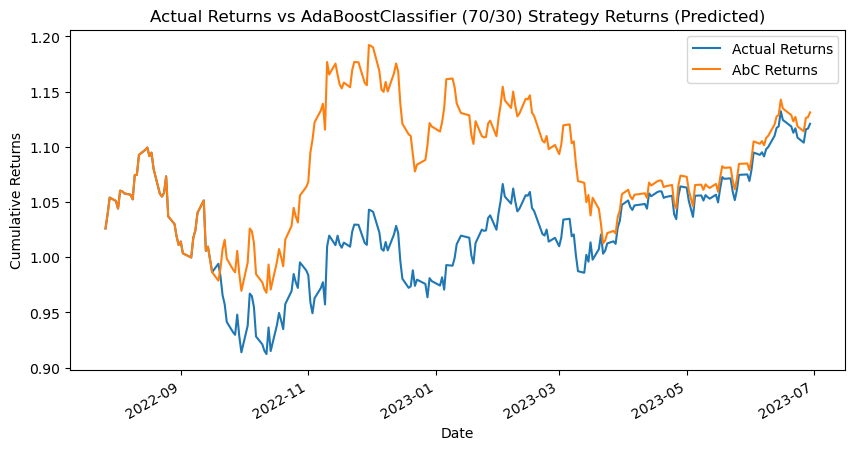

In [87]:
# Plot the actual returns versus the strategy returns


lrfig, ax = plt.subplots(figsize=(10, 5))
(1 + abc_predictions_df[['Actual Returns','AbC Returns']]).cumprod().plot(ax=ax)

# Set plot title and labels
ax.set_title('Actual Returns vs AdaBoostClassifier (70/30) Strategy Returns (Predicted)')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# Save the plot as a PNG file
plt.savefig('./Results/abc30_returns_plot.png')

# Display the plot
plt.show()

In [86]:
from watermark import watermark
print(watermark())
print(watermark(iversions=True, globals_=globals(), packages=""))

Last updated: 2023-07-07T21:37:56.224394-07:00

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 4, GenuineIntel
CPU cores   : 12
Architecture: 64bit

sklearn                : 1.2.2
talib                  : 0.4.19
numpy                  : 1.24.3
yfinance               : 0.2.18
hvplot                 : 0.8.3
pandas                 : 1.5.3
matplotlib             : 3.7.1
pandas_market_calendars: 4.1.4

